In [123]:
%load_ext autoreload
%autoreload 2

import numpy as np
from PIL import Image
import tifffile
import napari
from matplotlib import pyplot as plt
from skvideo import io as skvideo_io

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
from seghub.classif_utils import get_kmeans_clusters, get_pca_features
from seghub.convpaint_utils import get_convpaint_features_targets_model, get_convpaint_feature_space
from seghub.dino_utils import get_dinov2_patch_features, get_dinov2_pixel_features, get_dinov2_features_targets, get_dinov2_feature_space
from seghub.ilastik_utils import get_ila_features_targets, get_ila_feature_space
from seghub.rf_utils import train_seg_forest, predict_seg_forest_single_image, predict_seg_forest

In [125]:
shark_vid = skvideo_io.vread("../data/shark_test_vid.AVI")
print(shark_vid.shape)

(744, 480, 640, 3)


In [126]:
img = shark_vid[0]
# img = img[:,:,0]
print(img.shape)

(480, 640, 3)


In [127]:
v = napari.view_image(img)

In [128]:
# labels = v.layers['Labels'].data
# tifffile.imsave("../data/shark_vid_labels_frame0.tif", labels.astype(np.uint8))

labels = tifffile.imread("../data/shark_vid_labels_frame0.tif")
print(labels.shape)
print(np.sum(labels > 0))

(480, 640)
2480


## Convpaint

In [129]:
feature_space = get_convpaint_feature_space(img, layer_list=[0], scalings=[1,2], model_name="vgg16")
print(feature_space.shape)

(480, 640, 384)


In [130]:
# Because of edge problems in the current version of convpaint, we exclude the edge features
overall_means = np.mean(np.mean(feature_space, axis=0),axis=0)
feature_space[:5] = overall_means
feature_space[-5:] = overall_means
feature_space[:,:5] = overall_means
feature_space[:,-5:] = overall_means

In [131]:
v.add_image(np.moveaxis(feature_space, -1, 0), name="Feature Space Convpaint")

<Image layer 'Feature Space Convpaint' at 0x24d4902a370>

In [132]:
kmeans = get_kmeans_clusters(feature_space, num_clusters=2)
print(kmeans.shape)

(480, 640)


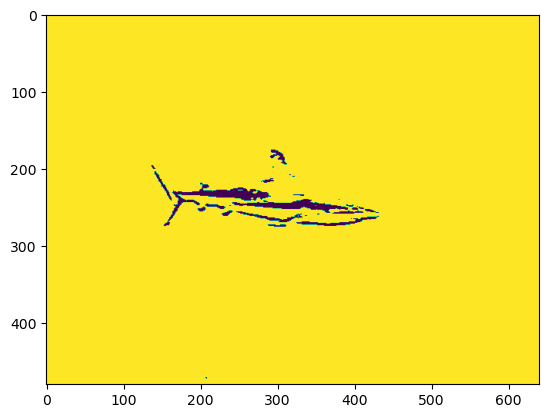

In [133]:
plt.imshow(kmeans)

In [134]:
pc = get_pca_features(feature_space, num_components=10)
print(pc.shape)

(480, 640, 10)


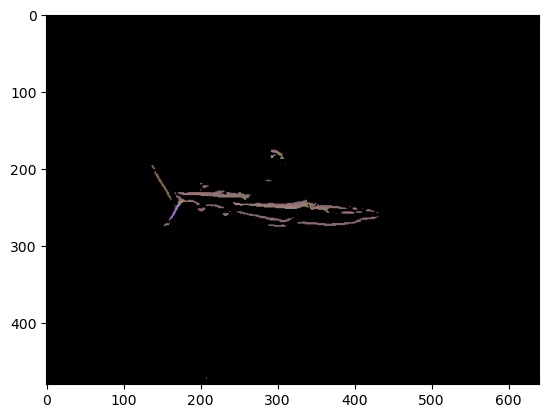

In [135]:
three_pc = pc[:,:,:3].copy()
pc_mask = pc[:,:,0]<0.5
three_pc[pc_mask] = 0
plt.imshow(three_pc)

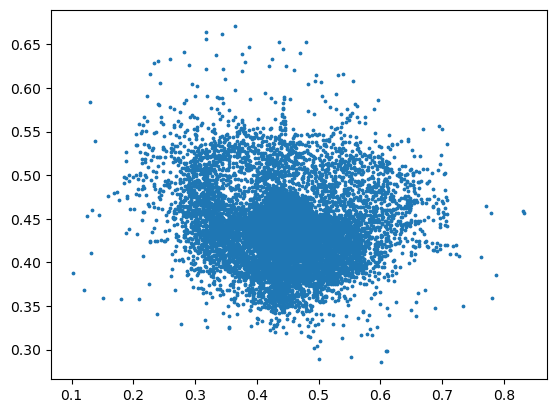

In [136]:
pc_1d = pc.reshape(-1, 10)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [137]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=2)
print(kmeans_p.shape)

(480, 640)


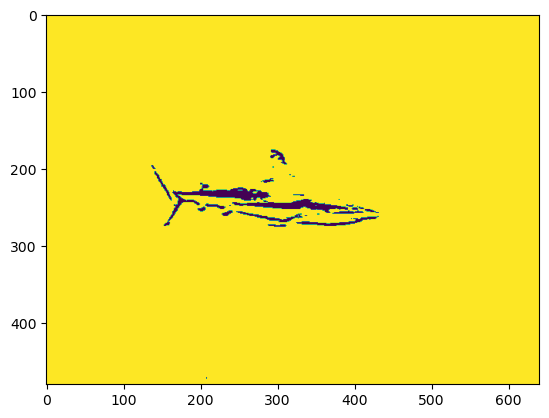

In [138]:
plt.imshow(kmeans_p)

In [139]:
annot_features, targets, model = get_convpaint_features_targets_model(img, labels, layer_list=[0], scalings=[1,2], model_name="vgg16")
print(annot_features.shape)
print(targets.shape)

(2480, 384)
(2480,)


In [140]:
pc_annot = get_pca_features(annot_features, num_components=10)
print(pc_annot.shape)

(2480, 10)


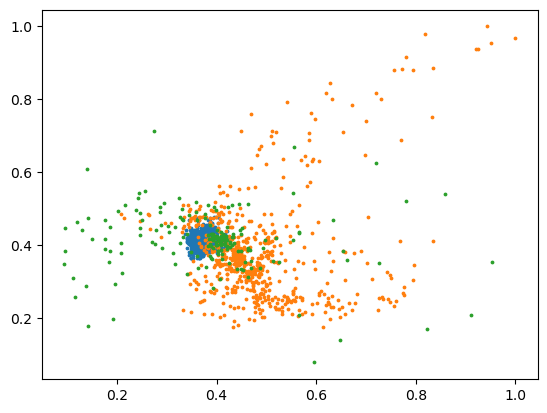

In [141]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## DINOv2

In [142]:
patch_features = get_dinov2_patch_features(img)
print(patch_features.shape)

(1610, 384)


In [143]:
pix_features = get_dinov2_pixel_features(img, interpolate_features=False)
print(pix_features.shape)

(307200, 384)


In [144]:
feature_space = get_dinov2_feature_space(img, interpolate_features=False)
print(feature_space.shape)

(480, 640, 384)


In [145]:
v.add_image(np.moveaxis(feature_space, -1, 0), name="Feature Space DINOv2")

<Image layer 'Feature Space DINOv2' at 0x24d4bafbd00>

In [146]:
kmeans_f = get_kmeans_clusters(feature_space, num_clusters=2)
print(kmeans_f.shape)

(480, 640)


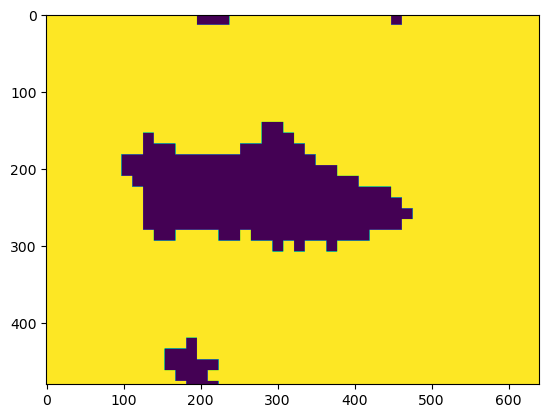

In [147]:
plt.imshow(kmeans_f)

In [148]:
pc = get_pca_features(feature_space, num_components=10)
print(pc.shape)

(480, 640, 10)


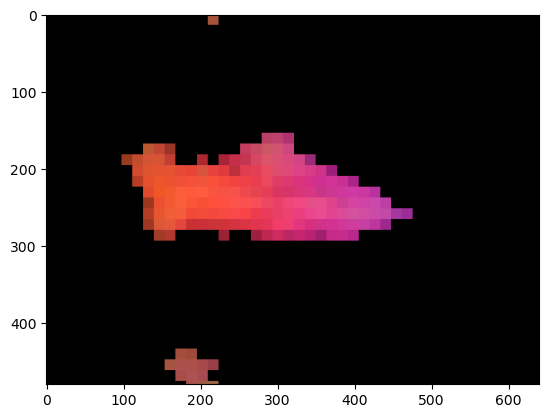

In [149]:
three_pc = pc[:,:,:3].copy()
pc_mask = pc[:,:,0]<0.6
three_pc[pc_mask] = 0
plt.imshow(three_pc)

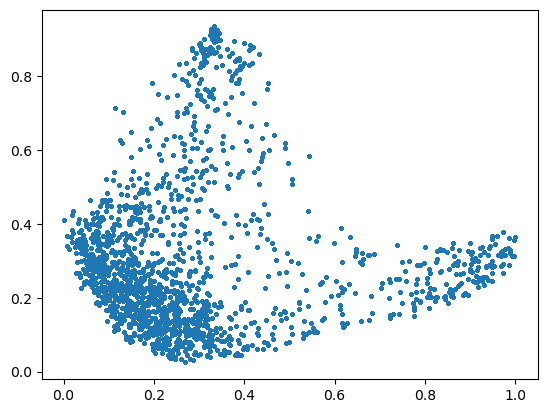

In [150]:
pc_1d = pc.reshape(-1, 10)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [151]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=2)
print(kmeans_p.shape)

(480, 640)


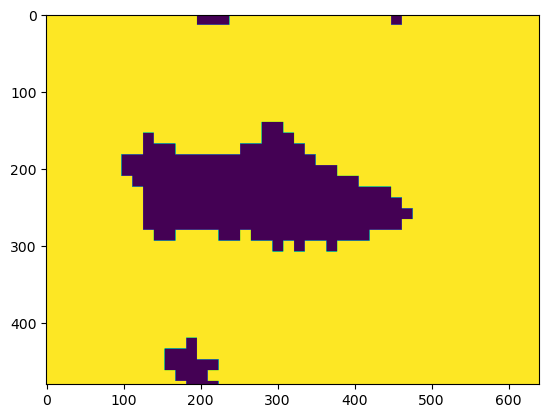

In [152]:
plt.imshow(kmeans_p)

In [153]:
annot_features, targets = get_dinov2_features_targets(img, labels, interpolate_features=False)
print(annot_features.shape)
print(targets.shape)

(2480, 384)
(2480,)


In [154]:
pc_annot = get_pca_features(annot_features, num_components=10)
print(pc_annot.shape)

(2480, 10)


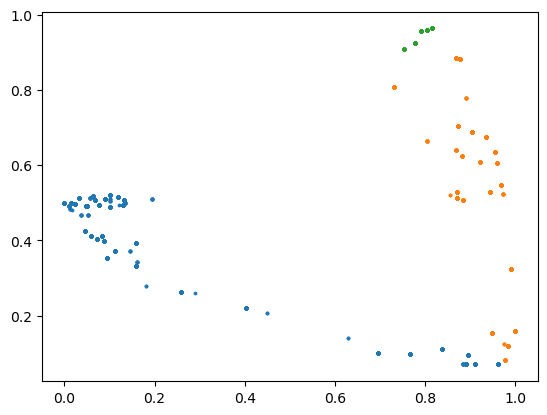

In [155]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## Ilastik

In [156]:
feature_space = get_ila_feature_space(img)
print(feature_space.shape)

(480, 640, 168)


In [157]:
v.add_image(np.moveaxis(feature_space, -1, 0), name="Feature Space Ilastik")

<Image layer 'Feature Space Ilastik' at 0x24d4f04a130>

In [158]:
kmeans_f = get_kmeans_clusters(feature_space, num_clusters=2)
print(kmeans_f.shape)

(480, 640)


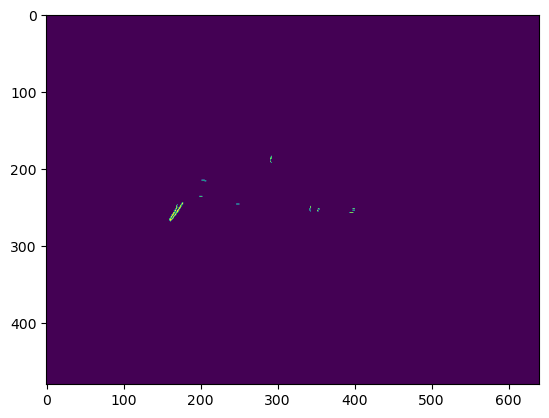

In [159]:
plt.imshow(kmeans_f)

In [160]:
pc = get_pca_features(feature_space, num_components=10)
print(pc.shape)

(480, 640, 10)


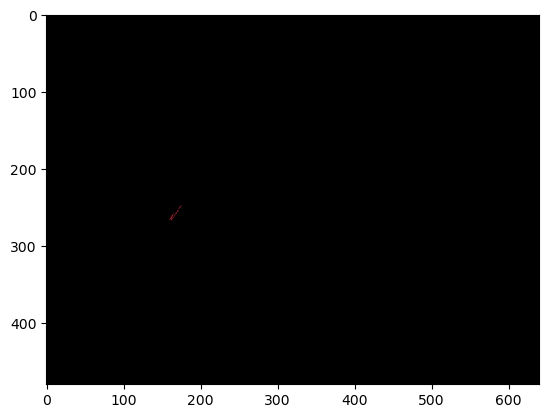

In [161]:
three_pc = pc[:,:,:3].copy()
pc_mask = pc[:,:,0]<0.5
three_pc[pc_mask] = 0
plt.imshow(three_pc)

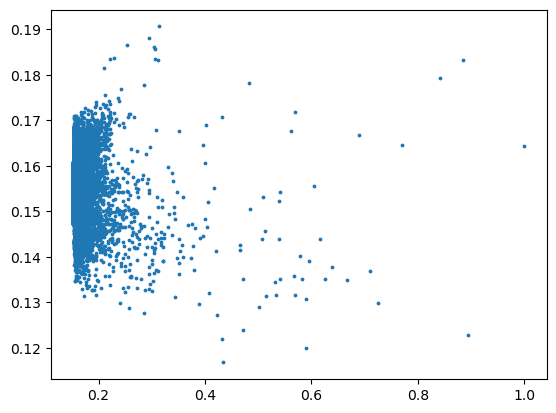

In [162]:
pc_1d = pc.reshape(-1, 10)
plt.scatter(pc_1d[:,0], pc_1d[:,1], s = 3)

In [163]:
kmeans_p = get_kmeans_clusters(pc, num_clusters=2)
print(kmeans_p.shape)

(480, 640)


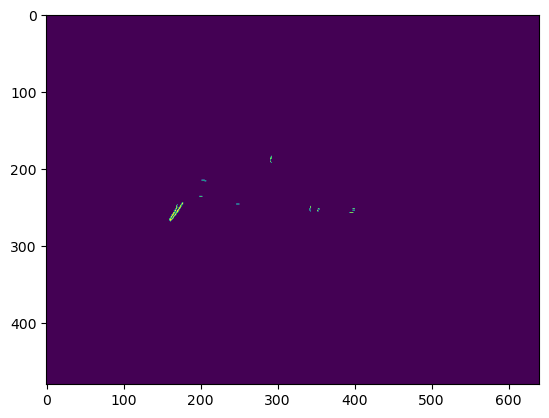

In [164]:
plt.imshow(kmeans_p)

In [165]:
annot_features, targets = get_ila_features_targets(img, labels)

In [166]:
pc_annot = get_pca_features(annot_features, num_components=10)
print(pc_annot.shape)

(2480, 10)


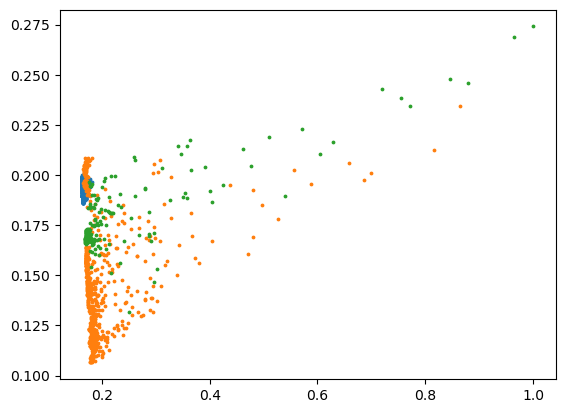

In [167]:
for c in np.unique(targets):
    plt.scatter(pc_annot[targets == c,0], pc_annot[targets == c,1], s = 3)

## Test random forest functions

In [168]:
# features_func_train = get_convpaint_features_targets_model
# features_func_pred = get_convpaint_feature_space
# features_cfg = {"layer_list": [0], "scalings": [1,2], "model_name": "vgg16"}
features_func_train = get_dinov2_features_targets
features_func_pred = get_dinov2_feature_space
# features_func_pred = get_dinov2_pixel_features
# features_func_pred = get_dinov2_patch_features
features_cfg = {"pc": 0}
# features_func_train = get_ila_features_targets
# features_func_pred = get_ila_feature_space
# features_cfg = {}

In [169]:
rf = train_seg_forest([img], [labels], features_func_train, features_cfg, print_steps=True, random_state=0)

Extracting features for labels 1/1 - estimated time left: NA


In [170]:
pred = predict_seg_forest_single_image(img, rf, features_func_pred, features_cfg, pred_per_patch=False, patch_size=(14,14))
print(pred.shape)

(480, 640)


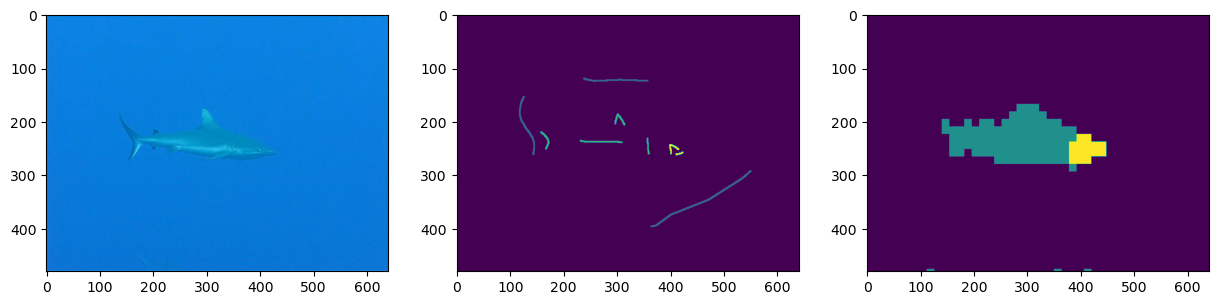

In [171]:
fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].imshow(img)
ax[1].imshow(labels)
ax[2].imshow(pred)

In [172]:
pred_vid = shark_vid.copy()
pred_vid = pred_vid[:40:4]

In [173]:
v2 = napari.view_image(pred_vid)

In [174]:
pred_batch = predict_seg_forest(pred_vid, rf, features_func_pred, features_cfg, pred_per_patch=False, patch_size=(14,14), print_steps=True)

Predicting image 1/10 - estimated time left: NA
Predicting image 2/10 - estimated time left: 90.1 seconds
Predicting image 3/10 - estimated time left: 80.0 seconds
Predicting image 4/10 - estimated time left: 66.6 seconds
Predicting image 5/10 - estimated time left: 55.3 seconds
Predicting image 6/10 - estimated time left: 45.0 seconds
Predicting image 7/10 - estimated time left: 36.8 seconds
Predicting image 8/10 - estimated time left: 28.1 seconds
Predicting image 9/10 - estimated time left: 19.1 seconds
Predicting image 10/10 - estimated time left: 9.8 seconds


In [175]:
v2.add_labels(pred_batch)

<Labels layer 'pred_batch' at 0x24d71e57f40>